### Figma Take Home Assessment

In [1]:
# Importing libraries and creating df

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('help_center_traffic.csv')

In [2]:
# Running df.dtypes to get the datatypes in the df and make sure they were read correctly

df.dtypes

day                     int64
country                object
browser                object
sessions                int64
sessions_with_cases     int64
dtype: object

In [3]:
# Looking at the df I created

df.head(12)

,day,country,browser,sessions,sessions_with_cases
0,1,A,Chrome,216,10
1,1,A,Firefox,66,3
2,1,A,Safari,31,1
3,1,A,Edge,17,0
4,1,A,Arc,19,0
5,1,B,Chrome,2792,83
6,1,B,Firefox,902,27
7,1,B,Safari,485,14
8,1,B,Edge,210,6
9,1,B,Arc,202,6


The CSV has sessions_with_cases and sessions to get the escalation rate. For the df above, there are different browsers, which this problem doesn't ask for, but may be looked into later. That means I will still have to do some aggregating before I get the escalation rate per country or per day. I will also look at the escalation rate per browser. The browser could be important because Figma is run primarily on a browser and not locally on a desktop version. 

### Part One - Analysis

In [4]:
# Creating a df for grouping by day and a new column for escalation rate

df_grouped_day = df.groupby('day').agg({'sessions_with_cases': 'sum', 'sessions': 'sum'})
df_grouped_day['escalation_rate'] = df_grouped_day['sessions_with_cases'] / df_grouped_day['sessions']

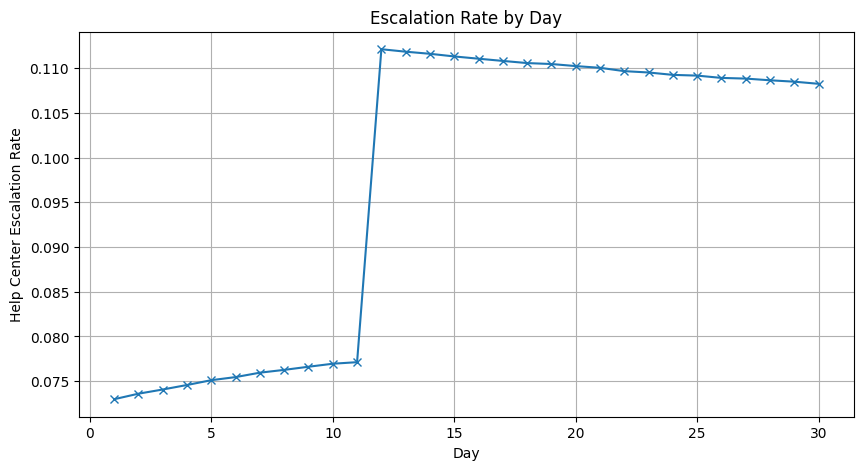

In [5]:

# Plotting the escalation rate by day

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_grouped_day.index, df_grouped_day['escalation_rate'], marker='x', linestyle='-')

# Labels and title
plt.xlabel('Day')
plt.ylabel('Help Center Escalation Rate')
plt.title('Escalation Rate by Day')
plt.grid(True)

# Show plot
plt.show()

In [6]:
# Creating a new df for grouping by country and a new column for escalation rate

df_grouped_country = df.groupby('country').agg({'sessions_with_cases': 'sum', 'sessions': 'sum'})
df_grouped_country['escalation_rate'] = df_grouped_country['sessions_with_cases'] / df_grouped_country['sessions']

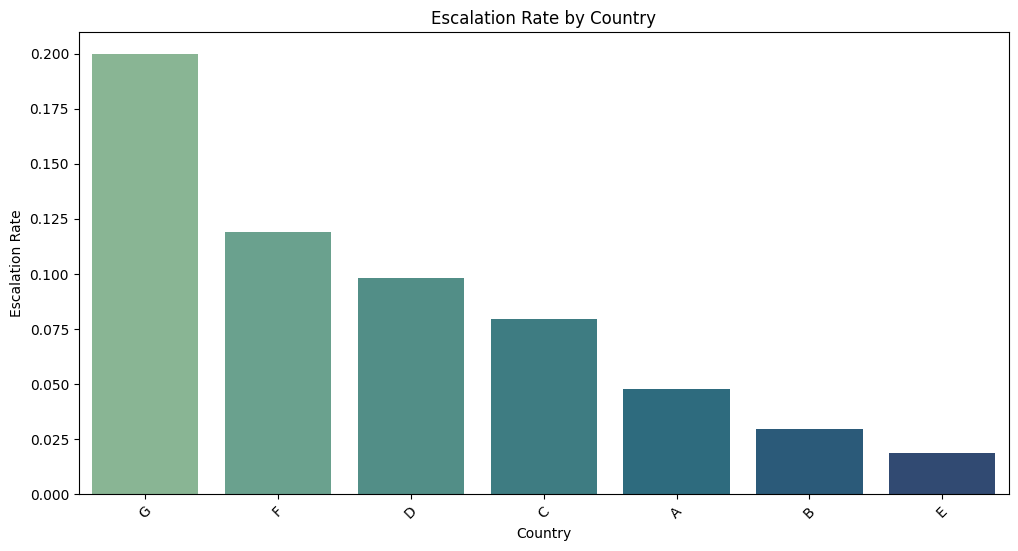

In [7]:
# Sorting values in descending order
df_sorted = df_grouped_country.reset_index().sort_values(by='escalation_rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='escalation_rate', data=df_sorted, hue='country', palette='crest')  # You can change the palette
plt.xlabel('Country')
plt.ylabel('Escalation Rate')
plt.title('Escalation Rate by Country')
plt.xticks(rotation=45)
plt.show()


In [8]:
df_grouped_browser = df.groupby('browser').agg({'sessions_with_cases': 'sum', 'sessions': 'sum'})
df_grouped_browser['escalation_rate'] = df_grouped_browser['sessions_with_cases'] / df_grouped_browser['sessions']

In [9]:
df_grouped_browser.head(10)

,sessions_with_cases,sessions,escalation_rate
browser,,,
Arc,4095,40532,0.101031
Chrome,49457,484925,0.101989
Edge,4067,40871,0.099508
Firefox,16182,159841,0.101238
Safari,8128,80971,0.100382


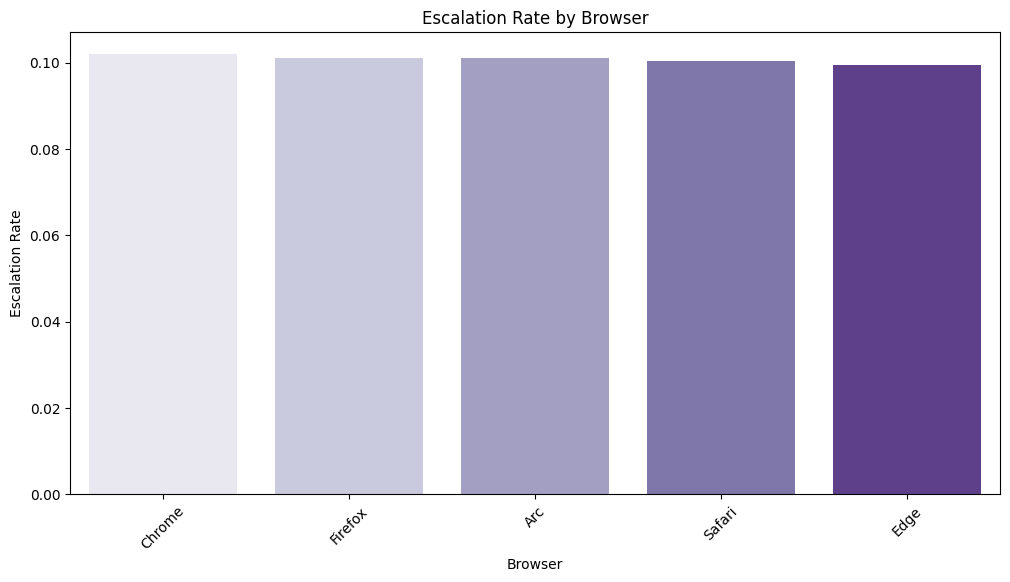

In [10]:
# Sorting values in descending order
df_sorted = df_grouped_browser.reset_index().sort_values(by='escalation_rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='browser', y='escalation_rate', data=df_sorted, hue='browser', palette='Purples')  # You can change the palette
plt.xlabel('Browser')
plt.ylabel('Escalation Rate')
plt.title('Escalation Rate by Browser')
plt.xticks(rotation=45)
plt.show()


### Part Two - Metric Decomposition

In [11]:
# Creating a copy of the original df just in case

df_decomp = pd.read_csv('help_center_traffic.csv')

##### Calculating Escalation Rate

In [20]:
def compute_metrics(df, group_cols):
    # Computes total sessions, escalation rate, rate effect, and proportion effect.

    # Step 1: Compute total sessions and escalation rate per group (country, day or browser, day)
    df_grouped = df.groupby(group_cols, as_index=False).agg(
        total_cases_by_day=('sessions_with_cases', 'sum'),
        total_sessions_by_day=('sessions', 'sum')
    )

    # Step 2: Compute escalation rate per group
    df_grouped['escalation_rate_by_day'] = df_grouped['total_cases_by_day'] / df_grouped['total_sessions_by_day']

    # Step 3: Compute total sessions across all groups (e.g., across all countries or browsers) per day
    total_sessions_per_day = df_grouped.groupby('day', as_index=False)['total_sessions_by_day'].sum()
    total_sessions_per_day.rename(columns={'total_sessions_by_day': 'total_sessions_all_groups'}, inplace=True)

    # Merge total sessions back to the grouped DataFrame
    df_grouped = df_grouped.merge(total_sessions_per_day, on='day', how='left')

    # Step 4: Compute the proportion of sessions for each group (country or browser) per day
    df_grouped['proportion_sessions'] = df_grouped['total_sessions_by_day'] / df_grouped['total_sessions_all_groups']

    # Step 5: Compute previous day's values using shift()
    # Dynamically use the group column (either 'country' or 'browser')
    group_column = group_cols[1]  # Get the second column ('country' or 'browser')
    
    df_grouped['prev_proportion_sessions'] = df_grouped.groupby(group_column)['proportion_sessions'].shift(1)
    df_grouped['prev_escalation_rate'] = df_grouped.groupby(group_column)['escalation_rate_by_day'].shift(1)

    # Step 6: Compute rate effect and proportion effect
    df_grouped['rate_effect'] = df_grouped['prev_proportion_sessions'] * (
        df_grouped['escalation_rate_by_day'] - df_grouped['prev_escalation_rate']
    )

    df_grouped['proportion_effect'] = (df_grouped['proportion_sessions'] - df_grouped['prev_proportion_sessions']) * df_grouped['prev_escalation_rate']

    # Step 7: Compute total change as the sum of rate effect and proportion effect
    df_grouped['total_change'] = df_grouped['rate_effect'] + df_grouped['proportion_effect']

    return df_grouped

# Example of applying the function to a DataFrame (e.g., `df_decomp`)
df_country_level = compute_metrics(df_decomp, ['day', 'country'])

# Verify the result
print(df_country_level.head())

# Example for browser level
df_browser_level = compute_metrics(df_decomp, ['day', 'browser'])

# Verify the result
print(df_browser_level.head())

   day country  total_cases_by_day  total_sessions_by_day  \
0    1       A                  14                    349   
1    1       B                 136                   4591   
2    1       C                 590                   7415   
3    1       D                  28                    295   
4    1       E                   4                    335   

   escalation_rate_by_day  total_sessions_all_groups  proportion_sessions  \
0                0.040115                      15893             0.021959   
1                0.029623                      15893             0.288869   
2                0.079568                      15893             0.466558   
3                0.094915                      15893             0.018562   
4                0.011940                      15893             0.021078   

   prev_proportion_sessions  prev_escalation_rate  rate_effect  \
0                       NaN                   NaN          NaN   
1                       NaN           

In [12]:
# Creating a function that can be used with the day/country grouping and day/browser grouping

def compute_metrics(df, group_cols):
    # Computes total sessions, escalation rate, rate effect, and proportion effect.

    # Step 1: Compute total sessions and escalation rate per group (country, day)
    df_grouped = df.groupby(group_cols, as_index=False).agg(
        total_cases_by_day=('sessions_with_cases', 'sum'),
        total_sessions_by_day=('sessions', 'sum')
    )

    df_grouped['escalation_rate_by_day'] = df_grouped['total_cases_by_day'] / df_grouped['total_sessions_by_day']

    # Step 2: Compute total sessions across all countries per day
    total_sessions_per_day = df_grouped.groupby('day', as_index=False)['total_sessions_by_day'].sum()
    total_sessions_per_day.rename(columns={'total_sessions_by_day': 'total_sessions_all_countries'}, inplace=True)

    # Merge total sessions back to the original DataFram
    df_grouped = df_grouped.merge(total_sessions_per_day, on='day', how='left')

    # Step 3: Compute the proportion of sessions for each country per day
    df_grouped['proportion_sessions'] = df_grouped['total_sessions_by_day'] / df_grouped['total_sessions_all_countries']

    # Step 4: Compute previous day's values using shift()
    df_grouped['prev_proportion_sessions'] = df_grouped.groupby('country')['proportion_sessions'].shift(1)
    df_grouped['prev_escalation_rate'] = df_grouped.groupby('country')['escalation_rate_by_day'].shift(1)

    # Step 5: Compute rate effect and proportion effect
    df_grouped['rate_effect'] = df_grouped['prev_proportion_sessions'] * (
        df_grouped['escalation_rate_by_day'] - df_grouped['prev_escalation_rate']
    )

    df_grouped['proportion_effect'] = (df_grouped['proportion_sessions'] - df_grouped['prev_proportion_sessions']) * df_grouped['prev_escalation_rate']

    # Step 6: Compute total change as the sum of rate effect and proportion effect
    df_grouped['total_change'] = df_grouped['rate_effect'] + df_grouped['proportion_effect']

    return df_grouped

# Example of applying the function to a DataFrame (e.g., `df_decomp`)
df_country_level = compute_metrics(df_decomp, ['day', 'country'])

# Verify the result
print(df_country_level.head())

   day country  total_cases_by_day  total_sessions_by_day  \
0    1       A                  14                    349   
1    1       B                 136                   4591   
2    1       C                 590                   7415   
3    1       D                  28                    295   
4    1       E                   4                    335   

   escalation_rate_by_day  total_sessions_all_countries  proportion_sessions  \
0                0.040115                         15893             0.021959   
1                0.029623                         15893             0.288869   
2                0.079568                         15893             0.466558   
3                0.094915                         15893             0.018562   
4                0.011940                         15893             0.021078   

   prev_proportion_sessions  prev_escalation_rate  rate_effect  \
0                       NaN                   NaN          NaN   
1                   

In [21]:
# Print specific columns asked for
df_country_level[['day', 'country', 'rate_effect', 'proportion_effect', 'total_change']].head(10)

,day,country,rate_effect,proportion_effect,total_change
0,1,A,NaN,NaN,NaN
1,1,B,NaN,NaN,NaN
2,1,C,NaN,NaN,NaN
3,1,D,NaN,NaN,NaN
4,1,E,NaN,NaN,NaN
5,1,F,NaN,NaN,NaN
6,1,G,NaN,NaN,NaN
7,2,A,0.000110,0.000101,0.000211
8,2,B,-0.000046,-0.000170,-0.000216
9,2,C,0.000027,-0.000592,-0.000565


In [22]:
df_decomp.head(10)

,day,country,browser,sessions,sessions_with_cases
0,1,A,Chrome,216,10
1,1,A,Firefox,66,3
2,1,A,Safari,31,1
3,1,A,Edge,17,0
4,1,A,Arc,19,0
5,1,B,Chrome,2792,83
6,1,B,Firefox,902,27
7,1,B,Safari,485,14
8,1,B,Edge,210,6
9,1,B,Arc,202,6


In [23]:
# Now, aggregate by day and browser
df_browser_level = df_decomp.groupby(['day', 'browser'], as_index=False).agg(
    sessions_with_cases=('sessions_with_cases', 'sum'),
    sessions=('sessions', 'sum')
)


In [24]:
df_browser_level.head(20)

,day,browser,sessions_with_cases,sessions
0,1,Arc,62,851
1,1,Chrome,710,9693
2,1,Edge,43,630
3,1,Firefox,231,3101
4,1,Safari,114,1618
5,2,Arc,61,913
6,2,Chrome,719,9671
7,2,Edge,60,820
8,2,Firefox,240,3302
9,2,Safari,120,1597


In [26]:
# Now apply the compute_metrics function
df_browser_level_metrics = compute_metrics(df_browser_level, ['day', 'browser'])

# Print the results
print(df_browser_level_metrics[['day', 'browser', 'rate_effect', 'proportion_effect', 'total_change']].head(20))

    day  browser  rate_effect  proportion_effect  total_change
0     1      Arc          NaN                NaN           NaN
1     1   Chrome          NaN                NaN           NaN
2     1     Edge          NaN                NaN           NaN
3     1  Firefox          NaN                NaN           NaN
4     1   Safari          NaN                NaN           NaN
5     2      Arc    -0.000324           0.000179     -0.000145
6     2   Chrome     0.000669          -0.001222     -0.000553
7     2     Edge     0.000195           0.000727      0.000922
8     2  Firefox    -0.000353           0.000553      0.000200
9     2   Safari     0.000477          -0.000271      0.000206
10    3      Arc     0.000258          -0.000607     -0.000349
11    3   Chrome     0.000194           0.000159      0.000353
12    3     Edge    -0.000112           0.000763      0.000651
13    3  Firefox     0.000362          -0.000940     -0.000577
14    3   Safari    -0.000212           0.000710      0